<a href="https://colab.research.google.com/github/prakashabhishek/deep_learning_with_tensorflow/blob/main/07_transfer_learning_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from helper_fun import *

%load_ext tensorboard

Using tensorflow version: 2.5.0


#### This time we are going to use pre-trained models available at [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications)

_dataset used is [10_food_classes_10_percent](https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip)_


```
unzip_data('../10_food_classes_10_percent.zip')
unzip_data('../10_food_classes_1_percent.zip')
```

In [5]:
# Run this cell when running on google colab

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data('10_food_classes_10_percent.zip')


!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data('10_food_classes_1_percent.zip')

In [7]:
walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'

In [7]:
def build_train_test_data(train_dir, test_dir, image_size = (224,224), batch_size = 32, seed = 42):
    
    train_dir = train_dir
    test_dir = test_dir
    

    train_data = tf.keras.preprocessing.image_dataset_from_directory(directory= train_dir,
                                                                    image_size = image_size,
                                                                    batch_size = batch_size,
                                                                    label_mode = 'categorical',
                                                                    seed = seed)

    test_data = tf.keras.preprocessing.image_dataset_from_directory(directory= test_dir,
                                                                   image_size = image_size,
                                                                   batch_size = batch_size,
                                                                   label_mode = 'categorical',
                                                                   seed = seed)
    
    
    return train_data, test_data

In [8]:
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32
RANDOM_SEED = 42

train_data, test_data = build_train_test_data(train_dir= '10_food_classes_10_percent/train/',
                                              test_dir= '10_food_classes_10_percent/test/', 
                                              image_size= IMAGE_SIZE, 
                                              batch_size= BATCH_SIZE, 
                                              seed= RANDOM_SEED)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### 1. Create model using tensorflow Functional API


**Creating base model with EfficientNet**

In [25]:
# Initialize EfficientNetB0 model from tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top= False)

# Freeze the base model (so the underlying learned patterns don't change)
base_model.trainable = False

# Create input to the model
inputs = tf.keras.layers.Input(shape= IMAGE_SIZE + (3,), name= 'input_layer')

# Normalize the inputs
# This step is not required here as EfficientNet has rescaling built-in but will be needed for other models
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(input)  

# Pass the inputs to base model
x = base_model(inputs)
print(f'Shape of x after passing inputs to model: {x.shape}')

# Average pool the outputs of base model
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_avg_pooling_layer')(x)
print(f'Shape of x after global pool operation: {x.shape}')

# Create the output activation layer
output = tf.keras.layers.Dense(10, activation = 'softmax', name = 'output_layer')(x)

# Combine the inputs and outputs into the model
model_1 = tf.keras.Model(inputs, output)

# Compile the model
model_1.compile(loss = CategoricalCrossentropy(),
               optimizer = Adam(),
               metrics = ['accuracy'])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs = 5,
                        steps_per_epoch= len(train_data),
                        validation_data= test_data,
                        validation_steps= 0.25*len(test_data),
                        callbacks = [create_tensorboard_callback('logs/', 'model_1')])

Shape of x after passing inputs to model: (None, 7, 7, 1280)
Shape of x after global pool operation: (None, 1280)
ERROR:tensorflow:Failed to start profiler: Another profiler is running.
Saving tensorboard log files to logs/model_1/20210530_181046
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 11s 263ms/step - loss: 1.9769 - accuracy: 0.3533 - val_loss: 1.4068 - val_accuracy: 0.7078
Epoch 2/5
24/24 [==============================] - 5s 208ms/step - loss: 1.1750 - accuracy: 0.7440 - val_loss: 0.9123 - val_accuracy: 0.8094
Epoch 3/5
24/24 [==============================] - 5s 206ms/step - loss: 0.8453 - accuracy: 0.8133 - val_loss: 0.7229 - val_accuracy: 0.8531
Epoch 4/5
24/24 [==============================] - 5s 201ms/step - loss: 0.6984 - accuracy: 0.8427 - val_loss: 0.6564 - val_accuracy: 0.8438
Epoch 5/5
24/24 [==============================] - 5s 208ms/step - loss: 0.6001 - accuracy: 0.8627 - val_loss: 0.6095 - val_accuracy: 0.8500


In [10]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pooling_layer (Gl (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [11]:
# Evaluate on full test dataset

model_1.evaluate(test_data)

79/79 [==============================] - 9s 110ms/step - loss: 0.6174 - accuracy: 0.8356


[0.6174021363258362, 0.8356000185012817]

In [12]:
for layer_num, layer in enumerate(base_model.layers):
    print(layer_num, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_3 (Rescaling)         (None, None, None, 3 0           input_4[0][0]                    
__________________________________________________________________________________________________
normalization_3 (Normalization) (None, None, None, 3 7           rescaling_3[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization_3[0][0]            
_____________________________________________________________________________________

In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 244, 244, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pooling_layer (Gl (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


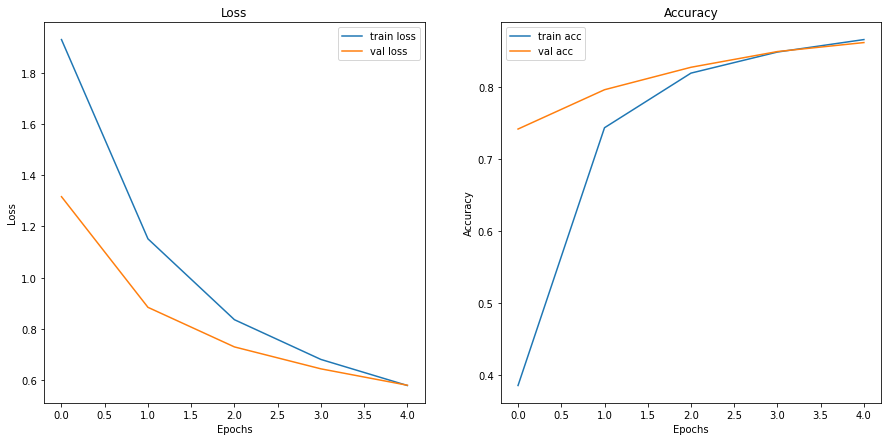

In [ ]:
plot_history(history_1)

### Getting feature vector from trained model

GlobalAveragePooling2D: It transforms a 4-D tensor to 2-D tensor

In [13]:
# Working of GlobalAveragePooling2D 

tf.random.set_seed(42)

input_shape = (1,4,4,3)

input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor: \n{input_tensor}')

# Pass random tensor through Global Average Pooling layer
global_avg_pool = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)

print(f'\nShape of input_tensor: {input_tensor.shape}')
print(f'\nGlobal avg pool tensor: {global_avg_pool}')
print(f'\nShape of global avg pooled tensor {global_avg_pool.shape}')

Random input tensor: 
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

Shape of input_tensor: (1, 4, 4, 3)

Global avg pool tensor: [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of global avg pooled tensor (1, 3)


In [ ]:
tf.reduce_mean(input_tensor, axis= [1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

In [ ]:
tf.reduce_max(input_tensor, axis= [1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

### Running a series of experiments

_**Note:** Throughout the experiments, same test dataset will be used_

1. Use feature extarction transfer learning with 1% of training data with data augmentation
2. Use feature extraction transfer learning with 10% of training data with data augmentation
3. Use fine-tuning transfer learning on 10% of training data with data augmentation
4. Use fine-tuning transfer learning on 100% of training data with data augmentation

##### Use feature extarction transfer learning with 1% of training data with data augmentation

In [14]:
train_data_1_per, test_data = build_train_test_data('10_food_classes_1_percent/train/',
                                                    '10_food_classes_1_percent/test/',
                                                     image_size= IMAGE_SIZE,
                                                     batch_size= BATCH_SIZE,
                                                     seed= RANDOM_SEED)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [15]:
# Adding data augmentation right into the model
# To add augmentation right into the model we can use the layers inside 
# tf.keras.layers.experimental.preprocessing()


# Create data augmentation layer with horizontal flipping, zoom, shear, etc.

data_augmentation = Sequential(layers = [
                                        tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                                        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
                                        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                                        tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
                                        tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
                                        tf.keras.layers.experimental.preprocessing.Rescaling(scale = 1./255)
                                        ],
                                name = 'data_augmentation')

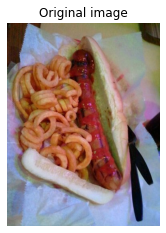

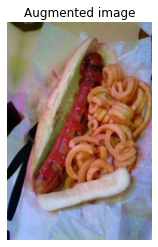

In [16]:
# PLotting some augmented images
img = mpimg.imread('10_food_classes_1_percent/train/chicken_wings/1528703.jpg')
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original image')
plt.axis(False)
plt.show()

plt.subplot(1,2,2)
img_aug = data_augmentation(tf.expand_dims(img, axis=0))

plt.imshow(tf.squeeze(img_aug))
plt.title('Augmented image')
plt.axis(False)
plt.show()


In [26]:
base_model = tf.keras.applications.EfficientNetB0(include_top= False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape= IMAGE_SIZE + (3,), name= 'input_layer')

x = data_augmentation(inputs)

# Give base_model the inputs and don't train it
x = base_model(x, training = False)

# Pool output features of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_avg_pool_layer')(x)

# Put a dense layer as output
outputs = Dense(10, activation = 'softmax', name = 'output_layer')(x)

# Make model using input and output layer
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss = CategoricalCrossentropy(),
               optimizer = Adam(),
               metrics = ['accuracy'])

history_2 = model_2.fit(train_data_1_per, 
                        epochs = 5,
                        steps_per_epoch = len(train_data_1_per),
                        validation_data = test_data,
                        validation_steps = 0.25*len(test_data),
                        callbacks = [create_tensorboard_callback(dir_name= 'logs/', experiment_name= 'model_2')])

ERROR:tensorflow:Failed to start profiler: Another profiler is running.
Saving tensorboard log files to logs/model_2/20210530_181139
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


3/3 [==============================] - 10s 2s/step - loss: 2.3744 - accuracy: 0.1000 - val_loss: 2.3029 - val_accuracy: 0.1156
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.3206 - accuracy: 0.1000 - val_loss: 2.3041 - val_accuracy: 0.0969
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 2.3129 - accuracy: 0.0571 - val_loss: 2.3071 - val_accuracy: 0.1016
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 2.3518 - accuracy: 0.0857 - val_loss: 2.3085 - val_accuracy: 0.0969
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 2.3388 - accuracy: 0.1000 - val_loss: 2.3055 - val_accuracy: 0.1000


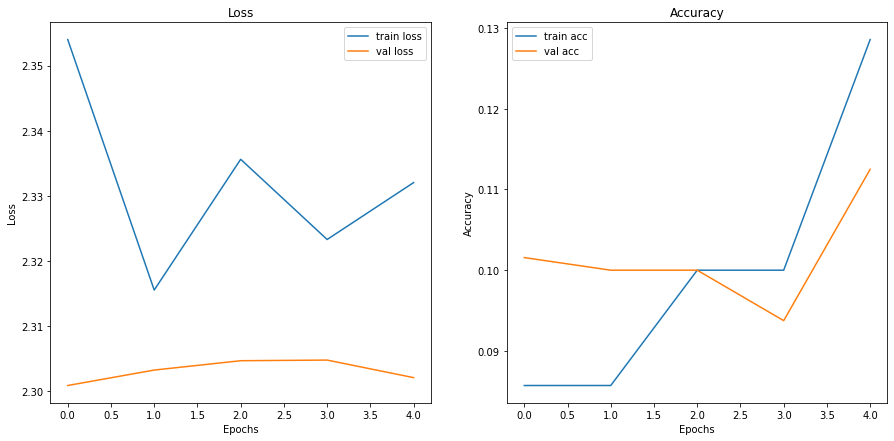

In [18]:
plot_history(history_2)

In [19]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_layer (Globa (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


#### Use feature extraction transfer learning with 10% of training data with data augmentation

In [ ]:
# Creating model checkpoint callback

def create_model_checkpoint_callback(dir_name, experiment_name):
    
    dir_path = os.path.join(dir_name, experiment_name, datetime.datetime.now().strftime('%Y%m%d_%H%M'))
    print(f'Model checkpoint saved at location: {dir_path}')
    
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath= dir_path,
                                                         save_best_only = True,
                                                         save_weights_only = True,
                                                         save_freq = 'epoch')
    
    return model_checkpoint

In [84]:
train_data_10_per, test_data = build_train_test_data('10_food_classes_10_percent/train/', '10_food_classes_10_percent/test/')

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [71]:
data_augmentation = Sequential(layers = [
                                            tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                                            tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
                                            tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
                                            tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
                                            tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                                            # tf.keras.layers.experimental.preprocessing.Rescaling(scale = 1./255)
                                        ],
                              name = 'data_augmentation_layer')

base_model = tf.keras.applications.EfficientNetB0(include_top= False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape = IMAGE_SIZE + (3,), name= 'input_layer')

x = data_augmentation(inputs)

x = base_model(x, training = False)

x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_avg_pool_layer')(x)

outputs = Dense(10, activation = 'softmax', name = 'output_layer')(x)

model_3 = tf.keras.Model(inputs, outputs, name = 'model_3')

model_3.compile(loss = CategoricalCrossentropy(),
               optimizer = Adam(),
               metrics = ['accuracy'])



In [72]:
model_3.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation_layer (Seq (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_layer (Globa (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [73]:
# model_ckpt = create_model_checkpoint_callback('checkpoints/', '10_perc_data_aug')
# tb_ckpt = create_tensorboard_callback('logs/', '10_perc_data_aug')
initial_epochs = 5
history_3 = model_3.fit(train_data_10_per,
                       epochs = initial_epochs,
                       steps_per_epoch = len(train_data_10_per),
                       validation_data = test_data,
                       validation_steps = int(0.25*len(test_data)),
                       callbacks = [create_tensorboard_callback('logs/', 'model_3'), 
                                    create_model_checkpoint_callback('checkpoints/', 'model_3')])

ERROR:tensorflow:Failed to start profiler: Another profiler is running.
Saving tensorboard log files to logs/model_3/20210530_184155
Model checkpoint saved at location: checkpoints/model_3/20210530_1841
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 14s 397ms/step - loss: 1.9636 - accuracy: 0.3600 - val_loss: 1.3954 - val_accuracy: 0.6891
Epoch 2/5
24/24 [==============================] - 8s 311ms/step - loss: 1.3409 - accuracy: 0.6653 - val_loss: 0.9990 - val_accuracy: 0.7681
Epoch 3/5
24/24 [==============================] - 8s 327ms/step - loss: 1.0556 - accuracy: 0.7320 - val_loss: 0.8006 - val_accuracy: 0.8174
Epoch 4/5
24/24 [==============================] - 8s 305ms/step - loss: 0.9050 - accuracy: 0.7813 - val_loss: 0.7049 - val_accuracy: 0.8388
Epoch 5/5
24/24 [==============================] - 7s 298ms/step - loss: 0.8212 - accuracy: 0.7827 - val_loss: 0.6701 - val_accuracy: 0.8289


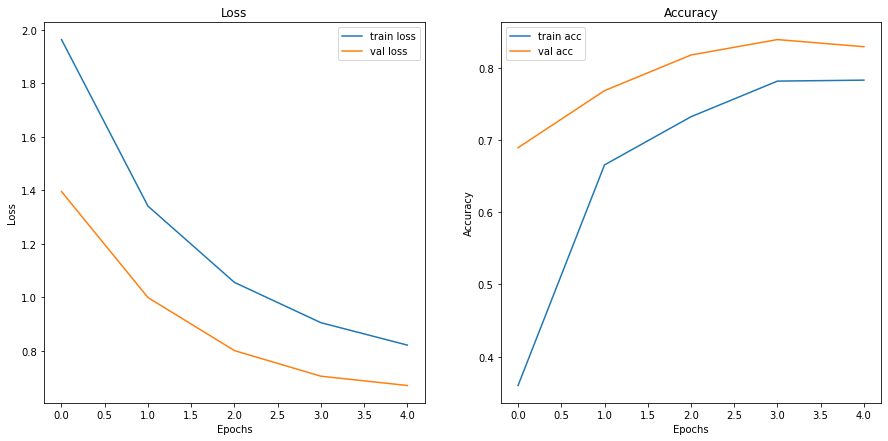

In [75]:
plot_history(history_3)

#### Use fine-tuning transfer learning on 10% of training data with data augmentation


We will use the previous model,i.e, model_3 for fine-tuning purpose

In [35]:
for layer_num, layer in enumerate(base_model.layers):
    print(layer_num, layer.name, layer.trainable)

0 input_8 False
1 rescaling_10 False
2 normalization_7 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resh

In [76]:
# To begin fine tuning, let's start by setting trainable=True for all the layers
base_model.trainable = True

# Freeze all layers except last 10 layers
for layer in base_model.layers[:-10]:
    layer.trainable = False

In [77]:
# Recompile the model as we have made changes to some layers
# Learning rate should very low for fine tuning as we don't want the weights 
# to change a lot as it will lead to over fitting

model_3.compile(loss = CategoricalCrossentropy(),
                optimizer = Adam(learning_rate= 0.0001), # lowering lr by 10x
                metrics = ['accuracy'])

In [78]:
model_3.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation_layer (Seq (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_layer (Globa (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 906,042
Non-trainable params: 3,156,339
_________________________________________________________________


In [79]:
model_3_fine_tuning_epoch = initial_epochs + 5

history_3_fine_tuning = model_3.fit(train_data_10_per,
                                    epochs = model_3_fine_tuning_epoch,
                                    steps_per_epoch = len(train_data_10_per),
                                    validation_data = test_data,
                                    validation_steps = int(0.25*len(test_data)),
                                    initial_epoch = history_3.epoch[-1],
                                    callbacks = [create_tensorboard_callback('logs/', 'model_3_fine_tuning'),
                                                 create_model_checkpoint_callback('checkpoints/', 'model_3__fine_tuning')])


ERROR:tensorflow:Failed to start profiler: Another profiler is running.
Saving tensorboard log files to logs/model_3_fine_tuning/20210530_184410
Model checkpoint saved at location: checkpoints/model_3__fine_tuning/20210530_1844
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 13s 348ms/step - loss: 0.6762 - accuracy: 0.8133 - val_loss: 0.4921 - val_accuracy: 0.8405
Epoch 6/10
24/24 [==============================] - 8s 314ms/step - loss: 0.5551 - accuracy: 0.8280 - val_loss: 0.4826 - val_accuracy: 0.8405
Epoch 7/10
24/24 [==============================] - 7s 300ms/step - loss: 0.5097 - accuracy: 0.8440 - val_loss: 0.4810 - val_accuracy: 0.8405
Epoch 8/10
24/24 [==============================] - 8s 314ms/step - loss: 0.4529 - accuracy: 0.8707 - val_loss: 0.4440 - val_accuracy: 0.8586
Epoch 9/10
24/24 [==============================] - 7s 284ms/step - loss: 0.4202 - accuracy: 0.8707 - val_loss: 0.4335 - val_accuracy: 0.8421
Epoch 10/10
24/24 [==============================] - 7s 282ms/step - loss: 0.3696 - accuracy: 0.8947 - val_loss: 0.4393 - val_accuracy: 0.8470


In [80]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.36000001430511475, 0.6653333306312561, 0.7319999933242798, 0.781333327293396, 0.7826666831970215, 0.8133333325386047, 0.828000009059906, 0.843999981880188, 0.8706666827201843, 0.8706666827201843, 0.8946666717529297]


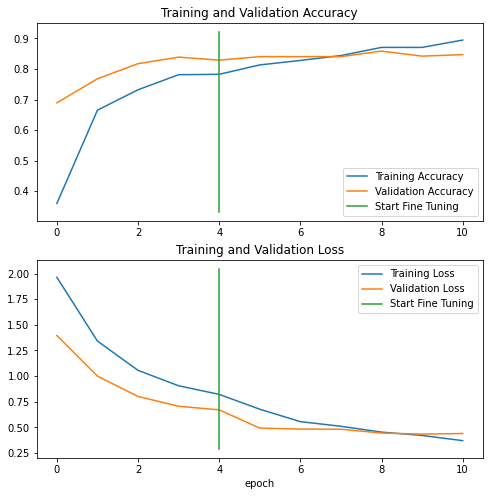

In [81]:
compare_historys(history_3, history_3_fine_tuning)

#### Use fine-tuning transfer learning on 100% of training data with data augmentation

In [82]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data('10_food_classes_all_data.zip')

--2021-05-30 18:49:37--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.128, 142.250.141.128, 2607:f8b0:4023:c06::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   239MB/s    in 2.1s    

2021-05-30 18:49:39 (239 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [91]:
# Setup train and test dir

train_dir = '10_food_classes_all_data/train'
test_dir = '10_food_classes_all_data/test'

train_data_all, test_data = build_train_test_data(train_dir, test_dir)


Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [92]:
walk_through_dir(train_dir)

There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.


In [93]:
# Load weights from checkpoint from the same stage on model_3 where 10 percent of data was trained
# before fine tuning was done on same 10 percent of data

model_3.load_weights(filepath= 'checkpoints/model_3/20210530_1841')

To summarize the steps done above from model_3 onwards:
1. Trained a feature extraction transfer learning model on 10% of data for 5 epochs and we saved the model weights using `ModelCheckpoint` callback
2. Fine tuned the above model by unfreezing top 10 layers of the base model for another 5 epochs using same 10% data
3. Reloaded the from step 1 and do the same steps as step 3 but this time we will use 100% of the data

In [96]:
# Check which of the layers as still trainable
for layer_num, layers in enumerate(model_3.layers):
    print(layer_num, layers.name, layers.trainable)

0 input_layer True
1 data_augmentation_layer True
2 efficientnetb0 True
3 global_avg_pool_layer True
4 output_layer True


In [97]:
# Let's see if the base_model's layers are still trainable
for layer_num, layers in enumerate(model_3.layers[2].layers):
    print(layer_num, layers.name, layers.trainable)

0 input_13 False
1 rescaling_20 False
2 normalization_12 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_re

In [98]:
# Since we have made some changes to the model(loaded weights from previous timestamp),
#  we need to recompile the model

model_3.compile(loss= CategoricalCrossentropy(),
                optimizer = Adam(learning_rate = 0.0001),
                metrics = ['accuracy'])


fine_tune_epochs = initial_epochs + 5
history_3_fine_tuning_full_data = model_3.fit(train_data_all,
                                            epochs = fine_tune_epochs,
                                            steps_per_epoch = len(train_data_all),
                                            validation_data = test_data,
                                            validation_steps = int(0.25*len(test_data)),
                                            initial_epoch = history_3.epoch[-1],
                                            callbacks = [create_tensorboard_callback('logs/', 'model_3_fine_tuning_all'),
                                                        create_model_checkpoint_callback('checkpoints/', 'model_3__fine_tuning_all')])


ERROR:tensorflow:Failed to start profiler: Another profiler is running.
Saving tensorboard log files to logs/model_3_fine_tuning_all/20210530_191235
Model checkpoint saved at location: checkpoints/model_3__fine_tuning_all/20210530_1912
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


235/235 [==============================] - 47s 173ms/step - loss: 0.7200 - accuracy: 0.7673 - val_loss: 0.3777 - val_accuracy: 0.8717
Epoch 6/10
235/235 [==============================] - 51s 214ms/step - loss: 0.5772 - accuracy: 0.8144 - val_loss: 0.3264 - val_accuracy: 0.8980
Epoch 7/10
235/235 [==============================] - 46s 196ms/step - loss: 0.5265 - accuracy: 0.8320 - val_loss: 0.2779 - val_accuracy: 0.9178
Epoch 8/10
235/235 [==============================] - 45s 191ms/step - loss: 0.4838 - accuracy: 0.8428 - val_loss: 0.3319 - val_accuracy: 0.8964
Epoch 9/10
235/235 [==============================] - 45s 189ms/step - loss: 0.4528 - accuracy: 0.8540 - val_loss: 0.3083 - val_accuracy: 0.9095
Epoch 10/10
235/235 [==============================] - 42s 175ms/step - loss: 0.4147 - accuracy: 0.8657 - val_loss: 0.2958 - val_accuracy: 0.9211


In [101]:
model_3.evaluate(test_data)

79/79 [==============================] - 9s 104ms/step - loss: 0.2993 - accuracy: 0.9052


[0.29932689666748047, 0.9052000045776367]

In [103]:
!zip -r transfer_learning_checkpoints.zip checkpoints/

  adding: checkpoints/ (stored 0%)
  adding: checkpoints/model_3/ (stored 0%)
  adding: checkpoints/model_3/20210530_1841.index (deflated 77%)
  adding: checkpoints/model_3/20210530_1834.data-00000-of-00001 (deflated 8%)
  adding: checkpoints/model_3/checkpoint (deflated 39%)
  adding: checkpoints/model_3/20210530_1826.data-00000-of-00001 (deflated 8%)
  adding: checkpoints/model_3/20210530_1834.index (deflated 77%)
  adding: checkpoints/model_3/20210530_1812.index (deflated 77%)
  adding: checkpoints/model_3/20210530_1812.data-00000-of-00001 (deflated 8%)
  adding: checkpoints/model_3/20210530_1826.index (deflated 77%)
  adding: checkpoints/model_3/20210530_1841.data-00000-of-00001 (deflated 8%)
  adding: checkpoints/model_3__fine_tuning/ (stored 0%)
  adding: checkpoints/model_3__fine_tuning/checkpoint (deflated 39%)
  adding: checkpoints/model_3__fine_tuning/20210530_1831.index (deflated 77%)
  adding: checkpoints/model_3__fine_tuning/20210530_1844.data-00000-of-00001 (deflated 8%)
